## 1. Load Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import pickle
import squarify
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.metrics import davies_bouldin_score

## 2. Load file RFM and stats

In [2]:
df = pd.read_csv('df_RFM.csv')
df.head(3)

,Member_number,Recency,Frequency,Monetary
0,2433,3,31,375.31
1,2193,91,27,361.45
2,1793,26,25,345.10


In [3]:
df.describe()

,Member_number,Recency,Frequency,Monetary
count,3898.000000,3898.000000,3898.000000,3898.000000
mean,3002.959979,187.701385,9.944844,85.212835
std,1155.806001,159.912688,5.310796,55.620089
min,1000.000000,0.000000,2.000000,1.300000
25%,1999.250000,57.000000,6.000000,43.810000
50%,3004.500000,141.000000,9.000000,74.900000
75%,4002.750000,280.000000,13.000000,115.295000
max,5000.000000,727.000000,36.000000,375.310000


In [4]:
#confirm null values and duplicate values
print(f"There has {df.isna().sum()} null values")
print(f"There has {df.duplicated().sum()} duplicated values")

There has Member_number    0
Recency          0
Frequency        0
Monetary         0
dtype: int64 null values
There has 0 duplicated values


## 3. Scale data and training model

#### 3.1. Scale data

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Recency', 'Frequency', 'Monetary']])

##### 3.2. Elbow method and Silhouette Score

* KMeans

In [6]:
sse = []
silhouette_scores = []
dbi_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)

    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    dbi_scores.append(davies_bouldin_score(scaled_data, kmeans.labels_))

C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1456, 

In [7]:
kl = KneeLocator(k_values, sse, curve='convex', direction='decreasing')
print(f"The optimal number of clusters is : {kl.elbow}")

The optimal number of clusters is : 4


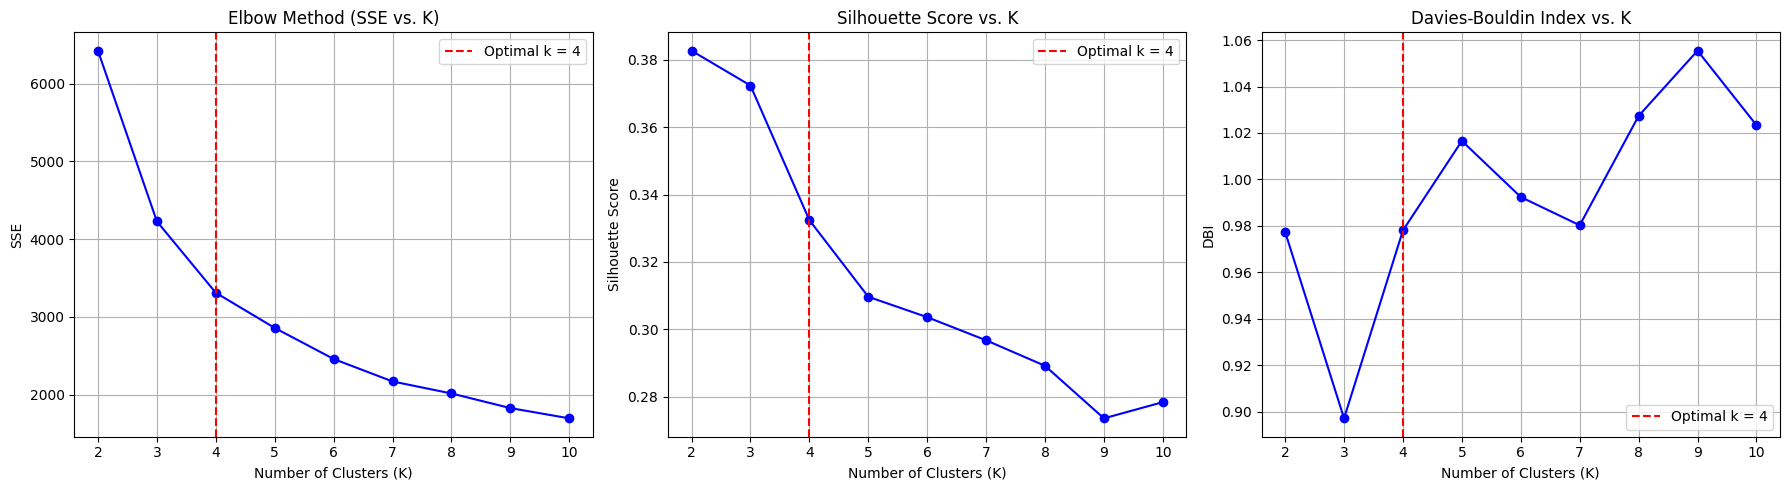

In [19]:
plt.figure(figsize=(18, 5))

# Biểu đồ Elbow Method (SSE vs. K)
plt.subplot(1, 3, 1)
plt.plot(k_values, sse, marker='o', color='b')
plt.title("Elbow Method (SSE vs. K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE")
plt.axvline(x=kl.elbow, color='r', linestyle='--', label=f'Optimal k = {kl.elbow}')
plt.legend()
plt.grid(True)

# Biểu đồ Silhouette Score vs. K
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title("Silhouette Score vs. K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.axvline(x=kl.elbow, color='r', linestyle='--', label=f'Optimal k = {kl.elbow}')
plt.legend()
plt.grid(True)

# Biểu đồ Davies-Bouldin Index vs. K
plt.subplot(1, 3, 3)
plt.plot(k_values, dbi_scores, marker='o', color='b')
plt.title("Davies-Bouldin Index vs. K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("DBI")
plt.axvline(x=kl.elbow, color='r', linestyle='--', label=f'Optimal k = {kl.elbow}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
k = 3
k_index = k_values.index(k)
print(f"*KMeans - k = {k}:")
print(f"  Silhouette Score: {round(silhouette_scores[k_index],2)}")

print("-"*50)
k = 4
k_index = k_values.index(k)
print(f"*KMeans - k = {k}:")
print(f"  Silhouette Score: {round(silhouette_scores[k_index],2)}")
print()

*KMeans - k = 3:
  Silhouette Score: 0.37
--------------------------------------------------
*KMeans - k = 4:
  Silhouette Score: 0.33



##### **Comments:**
Despite k = 3 achieving slightly better values in Silhouette and DBI, k = 4 emerges as the most suitable choice when all three metrics are considered:
- It marks the clearest elbow in the SSE curve.
- Maintains a reasonable silhouette score, avoiding oversimplification.
- DBI remains acceptable, without large penalties in cluster compactness.  
  
Thus, we conclude that k = 4 provides the most balanced and justifiable clustering solution, both statistically and practically.

#### 3.2. Train models

In [10]:
start_time = time.time()

In [11]:
k = 4
kmeans_model = KMeans(n_clusters=k, random_state=42)
kmeans_model.fit(scaled_data)

KMeans(n_clusters=4, random_state=42)

In [12]:
end_time_1 = time.time()

In [13]:
df['cluster'] = kmeans_model.predict(scaled_data)

In [14]:
end_time_2 = time.time()

In [15]:
print ("model training time:", round(end_time_1 - start_time,3),"sec")
print ("Prediction time:", round(end_time_2-end_time_1,3),"sec")

model training time: 0.066 sec
Prediction time: 0.063 sec


In [16]:
k = 4
k_index = k_values.index(k)
print(f"*KMeans - k = {k}:")
print(f"  Silhouette Score: {round(silhouette_scores[k_index],2)}")
print()

*KMeans - k = 4:
  Silhouette Score: 0.33



#### 3.3. Customer clustering visualization

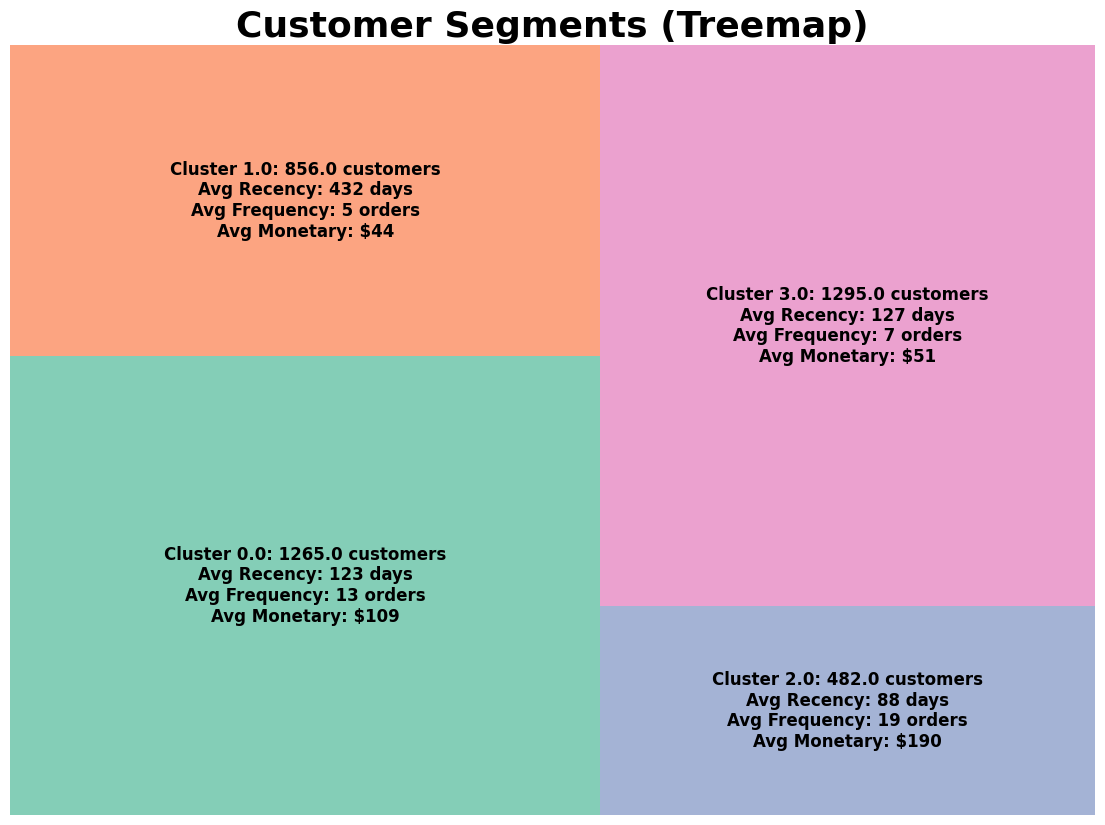

In [17]:
# Cluster summary
cluster_summary = df.groupby('cluster').agg(
    Count=('cluster', 'size'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).reset_index()

# Create labels
cluster_summary['label'] = [
    f"Cluster {row['cluster']}: {row['Count']} customers\nAvg Recency: {row['Avg_Recency']:.0f} days\nAvg Frequency: {row['Avg_Frequency']:.0f} orders\nAvg Monetary: ${row['Avg_Monetary']:.0f}"
    for _, row in cluster_summary.iterrows()
]

# Assign different colors using seaborn or matplotlib colormap
num_clusters = cluster_summary.shape[0]
colors = sns.color_palette("Set2", n_colors=num_clusters).as_hex()  # or use "Set3", "tab10", etc.

# Plot treemap with colors
fig = plt.figure(figsize=(14, 10))
squarify.plot(
    sizes=cluster_summary['Count'],
    label=cluster_summary['label'],
    color=colors,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"},
    alpha=0.8
)

plt.title("Customer Segments (Treemap)", fontsize=26, fontweight="bold")
plt.axis('off')
plt.show()

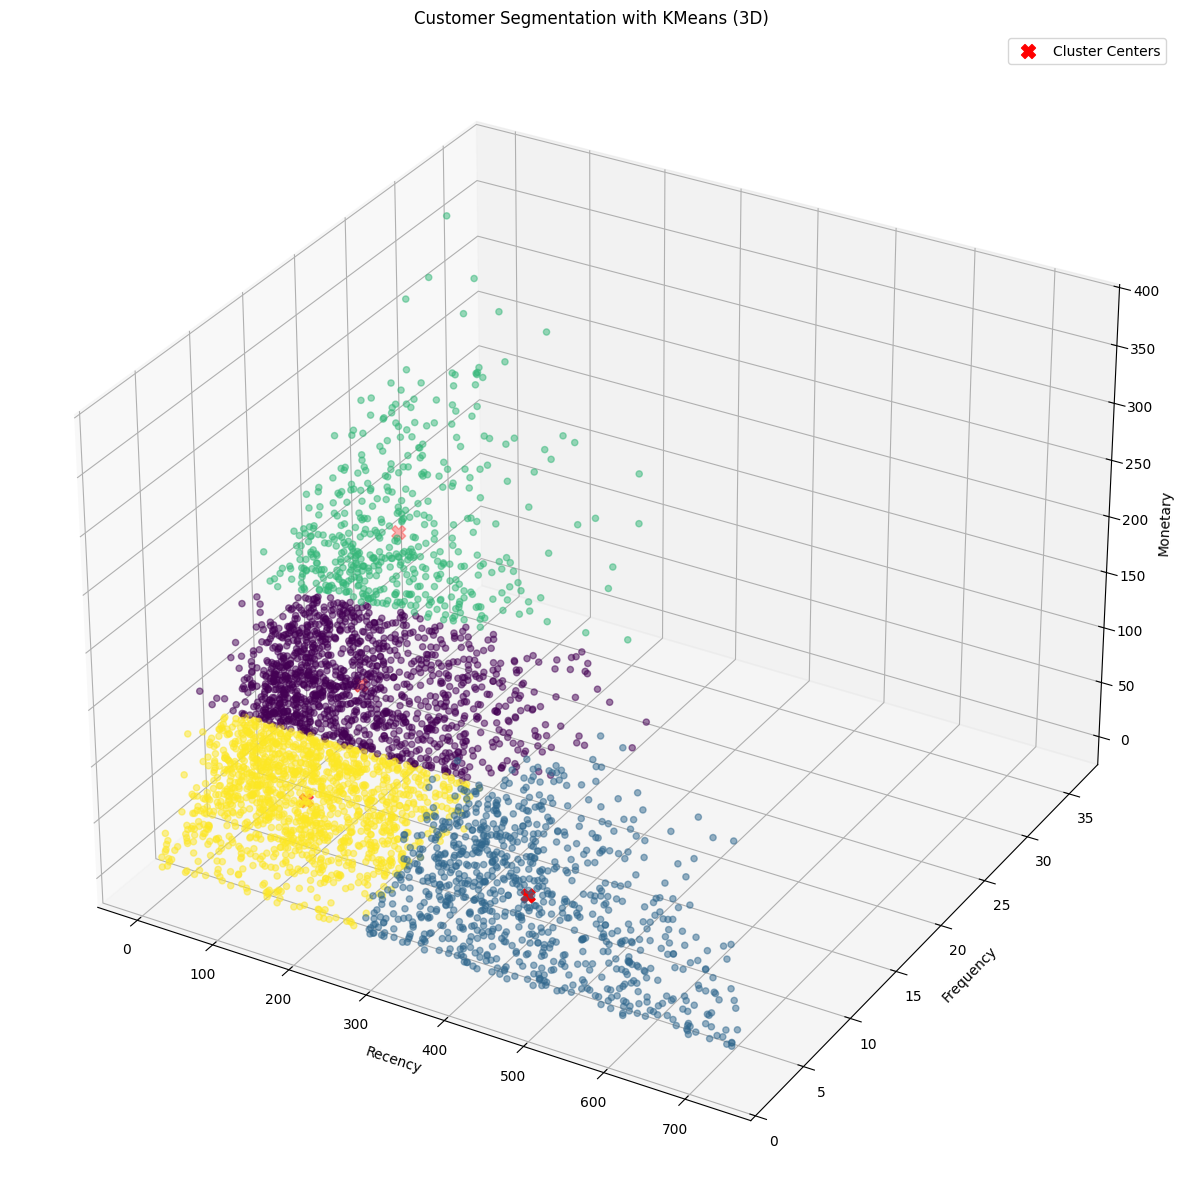

In [18]:
# Create the figure for 3D plotting
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the customer points (Recency, Frequency, Monetary)
scatter = ax.scatter(
    df['Recency'], df['Frequency'], df['Monetary'],
    c=df['cluster'], cmap='viridis', alpha=0.5
)

# Plot the cluster centroids
centroids = kmeans_model.cluster_centers_
centers = scaler.inverse_transform(centroids)

# Plot the centers only with Recency, Frequency, and Monetary (3D)
ax.scatter(
    centers[:, 0], centers[:, 1], centers[:, 2],
    c='red', s=100, marker='X', label='Cluster Centers'
)

# Set labels and title for the plot
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Customer Segmentation with KMeans (3D)')

# Add a legend
ax.legend()

# Show the plot
plt.show()

**comment:**
- Cluster separation is visible, indicating that the RFM features provide good discriminative power.
- One cluster (e.g., bottom-left) represents high-frequency, high-monetary, low-recency customers → likely loyal or high-value.
- Another cluster (e.g., far right on recency) captures inactive customers with high recency and low purchase values.
- The visual confirms that four segments are interpretable and actionable from a business standpoint.